In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('Twitter_Emotion_Dataset.csv')

In [3]:
data.head()

,label,tweet
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu..."
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng..."
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata..."


In [4]:
data['tweet_length'] = data['tweet'].apply(lambda x:len(x))

In [5]:
import re

In [6]:
def clean_text(x):
    letter_only=re.sub("[^a-zA-Z]", " ", x)
    return ' '.join(letter_only.split()).lower()

In [7]:
data['clean_tweet']=data['tweet'].apply(clean_text)

In [8]:
data['clean_tweet_length']=data['clean_tweet'].apply(lambda x : len(x))

### Find Meaningfull word on every document

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [10]:
count_vectorizer_transformer=CountVectorizer().fit(data['clean_tweet'])
count_vectorizer_res=count_vectorizer_transformer.transform(data['clean_tweet'])
tf_idf_transformer=TfidfTransformer().fit(count_vectorizer_res)
tf_idf_res=tf_idf_transformer.transform(count_vectorizer_res)
df_tf_idf = pd.DataFrame(tf_idf_res.todense(),columns=count_vectorizer_transformer.get_feature_names())

In [11]:
df_tf_idf.iloc[0].sort_values(ascending=False).head(3)

polisi      0.310086
gubernur    0.307813
soal        0.270716
Name: 0, dtype: float64

In [12]:
meaningfull_words = []
for item in range(len(data)):
    words = list(df_tf_idf.iloc[item].sort_values(ascending=False).head(3).index)
    meaningfull_words.append(words)

In [13]:
data['meaningfull words']=meaningfull_words

In [14]:
data.head()

,label,tweet,tweet_length,clean_tweet,clean_tweet_length,meaningfull words
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",220,soal jln jatibaru polisi tdk bs gertak gubernu...,209,"[polisi, gubernur, soal]"
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",235,sesama cewe lho kayaknya harusnya bisa lebih r...,226,"[rasain, wajarlah, paniknya]"
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,116,kepingin gudeg mbarek bu hj amad foto dari goo...,111,"[teman, gudeg, membayangkannya]"
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",250,jln jatibaru bagian dari wilayah tn abang peng...,244,"[wilayah, gub, wwnang]"
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata...",203,sharing pengalaman aja kemarin jam batalin tik...,186,"[jam, beress, twips]"


# EDA

In [15]:
from nltk.corpus import stopwords

In [16]:
from collections import Counter

In [17]:
def show_most_words_appear(data):
    all_words=' '.join(list(data))
    list_all_words = all_words.split()
    word_count = Counter(list_all_words)
    word_count_series=pd.Series(word_count)
    word_wo_stopwords = []
    for item in word_count_series.index:
        if(item not in stopwords.words('indonesian')):
            word_wo_stopwords.append(item)
    word_count_series=word_count_series.loc[word_wo_stopwords]
    most_words_appear =word_count_series.sort_values(ascending=False).head(20)
    plt.figure(figsize=(15,5))
    sns.barplot(most_words_appear.index, most_words_appear.values)

In [18]:
data.label.unique()

array(['anger', 'happy', 'sadness', 'love', 'fear'], dtype=object)

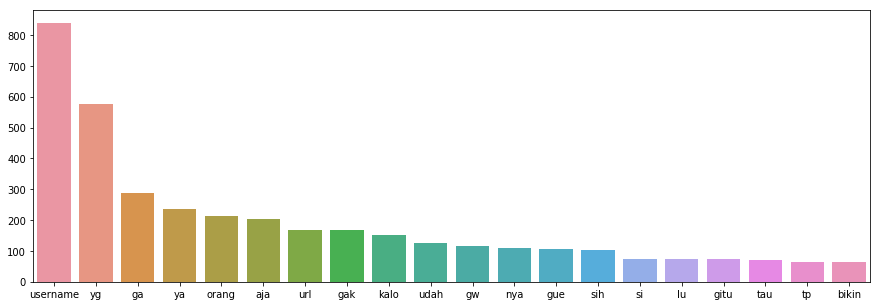

In [37]:
show_most_words_appear(data[data['label']=='anger']['clean_tweet'])

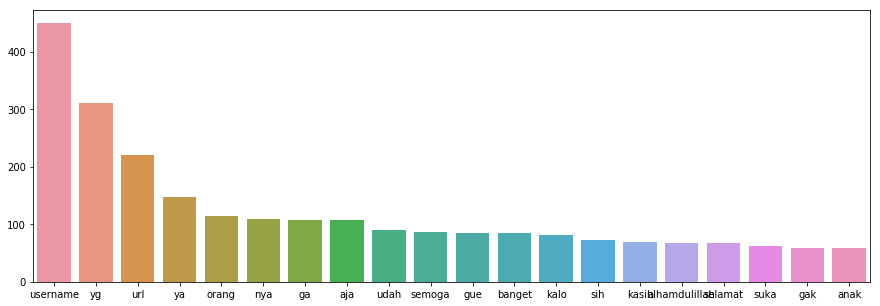

In [38]:
show_most_words_appear(data[data['label']=='happy']['clean_tweet'])

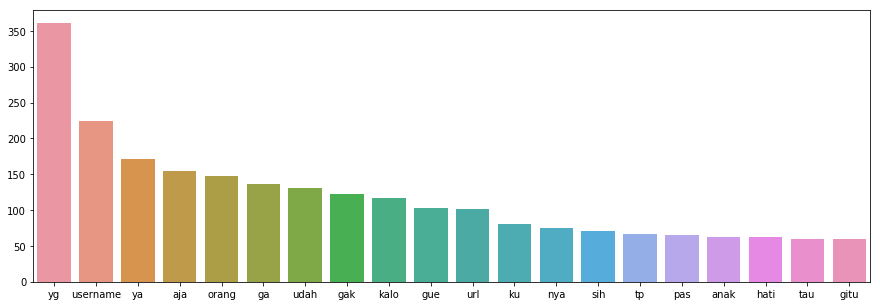

In [39]:
show_most_words_appear(data[data['label']=='sadness']['clean_tweet'])

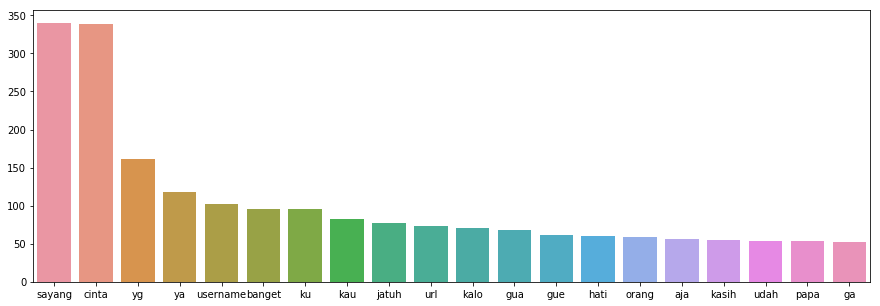

In [40]:
show_most_words_appear(data[data['label']=='love']['clean_tweet'])

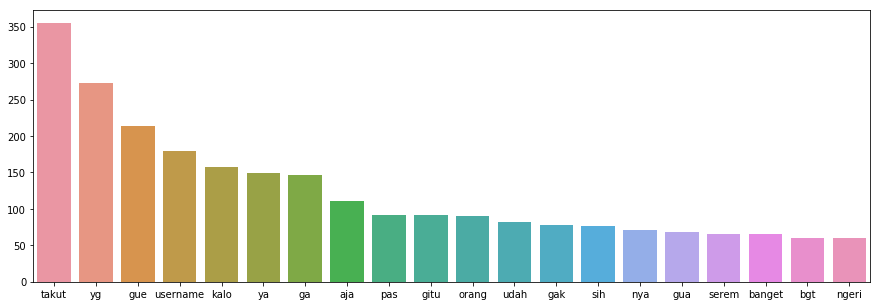

In [41]:
show_most_words_appear(data[data['label']=='fear']['clean_tweet'])

In [42]:
new_meaningfull = [' '.join(item) for item in data['meaningfull words']]

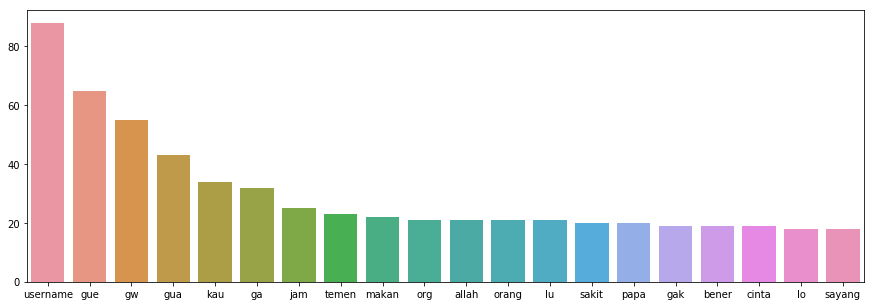

In [43]:
show_most_words_appear(pd.Series(new_meaningfull))

# Modelling

In [26]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import classification_report

In [27]:
X_train, X_test, y_train, y_test = tts(tf_idf_res, data['label'], random_state=101)

In [28]:
model_1 = MultinomialNB().fit(X_train, y_train)
prediction =model_1.predict(X_test)
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

       anger       0.56      0.81      0.66       284
        fear       0.96      0.15      0.26       170
       happy       0.71      0.43      0.54       269
        love       0.93      0.24      0.38       154
     sadness       0.34      0.68      0.45       224

   micro avg       0.51      0.51      0.51      1101
   macro avg       0.70      0.46      0.46      1101
weighted avg       0.66      0.51      0.49      1101



### Simple Prediction: 

In [29]:
mes = 'sekarang lo nyesel kan, kesel kan, putusin gue - younglex'
cv = count_vectorizer_transformer.transform([mes])
tf = tf_idf_transformer.transform(cv)
model_1.predict(tf)

array(['anger'], dtype='<U7')

In [30]:
mes = 'seandainya kau tahu ku tak ingin kau pergi meninggalkan ku sendiri bersama bayanganmu - vierra'
cv = count_vectorizer_transformer.transform([mes])
tf = tf_idf_transformer.transform(cv)
model_1.predict(tf)

array(['sadness'], dtype='<U7')

In [31]:
mes = 'ku tergetar saat menatap kedua matamu - danilla'
cv = count_vectorizer_transformer.transform([mes])
tf = tf_idf_transformer.transform(cv)
model_1.predict(tf)

array(['love'], dtype='<U7')

In [32]:
mes = 'indonesia tanah airku, tanah tumpah darahku'
cv = count_vectorizer_transformer.transform([mes])
tf = tf_idf_transformer.transform(cv)
model_1.predict(tf)

array(['happy'], dtype='<U7')

In [33]:
mes = 'kelurahan'
cv = count_vectorizer_transformer.transform([mes])
tf = tf_idf_transformer.transform(cv)
model_1.predict(tf)

array(['anger'], dtype='<U7')

In [35]:
mes = 'saya ingin sendiri'
cv = count_vectorizer_transformer.transform([mes])
tf = tf_idf_transformer.transform(cv)
model_1.predict(tf)

array(['sadness'], dtype='<U7')